# clean data

## import library

In [315]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## column index name

In [316]:
DIC_TITLE_INDEX = {"Admin": 0,"bank" : 0, "trade" : 0, "ceo":0,"community_service" : 0,"construction":0,"design" :0, "edu" : 0,"manufacture": 0, "acct" : 0, "advertising": 0,"call" : 0,  "consult" : 0 }
DIC_LINK_INDEX = {"Admin": 1,"bank" : 1, "trade" : 1, "ceo":1,"community_service" : 1,"construction":1,"design" :1, "edu" : 1,"manufacture": 1, "acct" : 1, "advertising": 1,"call" : 1,  "consult" : 1 }
DIC_COMPANY_INDEX = {"Admin": 2,"bank" : 2, "trade" : 2, "ceo":2,"community_service" : 2,"construction":2,"design" :2, "edu" : 2,"manufacture": 2, "acct" : 2, "advertising": 2,"call" : 2,  "consult" : 2 }
DIC_LOCATION_INDEX = {"Admin": 3,"bank" : 3, "trade" : 3, "ceo":3,"community_service" : 3,"construction":3,"design" :3, "edu" : 3,"manufacture": 3, "acct" : 3, "advertising": 3,"call" : 3,  "consult" : 3 }
DIC_POST_DAY_INDEX ={"Admin": 4,"bank" : 5, "trade" : 5, "ceo":5,"construction":5,"design" :5, "edu" : 5,"manufacture": 5, "acct" : 5, "advertising":6 ,"call" : 5,  "consult" : 5 }
DIC_CLASSI_INDEX ={"Admin": 5,"bank" : 6, "trade" : 6, "ceo":4,"community_service" : 5,"construction":6,"design" :6, "edu" : 4,"manufacture": 4, "acct" : 4, "advertising": 5,"call" : 6,  "consult" : 6 }
DIC_SALARY_INDEX  ={"edu":6,'manufacture':6,"acct" : 6,"advertising": 4,"call" : 6,"consult" : 6 }
LOCATION_INDEX = len('location:')
CLASSIFICATION_INDEX = len('classification:')


## read data

In [317]:
def read_data(file_path,job_name):
    """read csv_file with no header, then call each action of function"""
    csv_new =pd.read_csv(file_path,header= None)
    csv_new = csv_new.drop(csv_new.index[0])
    csv_new = clean_loc_and_area(csv_new,DIC_LOCATION_INDEX[job_name] )
    csv_new =  clean_salary(csv_new,DIC_CLASSI_INDEX[job_name])
    csv_new = clean_classification(csv_new,DIC_CLASSI_INDEX[job_name])
    csv_new = post_and_feature(csv_new, DIC_POST_DAY_INDEX[job_name])
    return csv_new

## clean the location and area column

In [318]:
def clean_loc_and_area(csv_new, index = 3):
    
    '''
    the funcation used to get rid of "location: " value, and also split the location into two piece,
    fill NA in the area and location column.Then, get rid of salary information in the location column,
    for example, #eg. abcabc,$23 per hour.
    Next, get rid of word "area" in the area column, then drop it.
    Finally, call duplicate area function.
    '''
    
    csv_new[index] = csv_new[index].apply(lambda x:x[LOCATION_INDEX:])
    csv_new[['area','location']] = csv_new[index].str.split('area: ', expand = True)
    csv_new['location'].fillna('unknown',inplace = True)
    csv_new['area'].fillna('unknown',inplace = True)
    csv_new['location'] = csv_new['location'].replace('(\,[\s\S]*)',"",regex = True)
    csv_new.drop(columns = [index],inplace = True)
    csv_new['location']= csv_new['location'].apply(dulplicate_loc)
    
    
    csv_new['area'] = csv_new['area'].replace('(area$)',"",regex = True)
    csv_new['area'] = csv_new['area'].replace('(\,[\s\S]*)',"",regex = True)
    csv_new['area'] = csv_new['area'].apply(dulplicate_area)
    
   
    
    return csv_new

## clean the dulplicate value in the location column

In [319]:
def dulplicate_loc(column):
    '''
    clean the dulplicate value in the location column
    '''
    mid = len(column)//2
    if column == 'unknown':
        return 'unknown'
    else:
        return column[mid:]

## clean the dulplicate value in the area column

In [320]:
def dulplicate_area(column):
    '''
    clean the dulplicate value in the area column
    '''
    mid = len(column)//2
    if column == 'unknown':
        return 'unknown'
    else:
        return column[mid+1:]

## clean the salary column

In [321]:
def clean_salary(csv_new,index):
    '''
    First, find salary information in the classification column by using salary funcation.
    Then, clean the salary column,split salary collumn into two pieces that are called high salary
    and low salary.
    Then extract number that what we want in the low_salary and high_salary column.
    If the low _salary is unknown, high_salary has a number, then put number also in the low_salary column.
    If the high_salary is unknown, low_salary has a number, then put number also in the high_salary column.
    Next, transfer low_salary and high_salary type.
    Count salary for a year in the low salary and high salary column.
    Finally, fill NA in the low salary and high salary column.
    '''
    
    csv_new['salary']= csv_new[index].apply(salary)
    
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d', na= False)]['salary'].str.replace('to','-',regex = True)
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d',na = False)]['salary'].str.replace(',','',regex = True)
    csv_new['salary'] = csv_new[csv_new['salary'].str.contains('\d',na = False)]['salary'].str.replace('\d\%','',regex = True)
 
    csv_new['salary'] = csv_new['salary'].fillna('unknown')
    
    csv_new[['low_salary','high_salary']] = csv_new['salary'].str.split('-',n = 1, expand = True)
    csv_new[['low_salary','high_salary']]=csv_new[['low_salary','high_salary']].fillna('unknown')
    
    csv_new['low_salary'] = csv_new['low_salary'].str.extract(r'(\d+\.\d+|\d+ \d+|\d+k|\d+)',expand = False)
    csv_new['high_salary'] = csv_new['high_salary'].str.extract(r'(\d+\.\d+|\d+ \d+|\d+k|\d+)',expand = False) 
    
    csv_new['low_salary'] = csv_new[csv_new['low_salary'].str.contains('\d',na= False)]['low_salary'].str.replace(' ','',regex = True)
    csv_new['high_salary'] = csv_new[csv_new['high_salary'].str.contains('\d',na= False)]['high_salary'].str.replace(' ','',regex = True)
    
    csv_new['low_salary'] = csv_new[csv_new['low_salary'].str.contains('\d',na = False)]['low_salary'].str.replace('k','000',regex = True)
    csv_new['high_salary'] = csv_new[csv_new['high_salary'].str.contains('\d',na = False)]['high_salary'].str.replace('k','000',regex = True)

    
    csv_new.loc[csv_new['low_salary']=='unknown','low_salary'] = csv_new['high_salary']
    csv_new.loc[csv_new['high_salary']=='unknown','high_salary'] = csv_new['low_salary']
    
    csv_new['low_salary'] = csv_new['low_salary'].astype('float32')
    csv_new['high_salary'] = csv_new['high_salary'].astype('float32')
    
    csv_new.loc[csv_new['low_salary'] < 50, 'low_salary'] = csv_new['low_salary'] * 8*200
    csv_new.loc[csv_new['high_salary'] < 50, 'high_salary'] = csv_new['high_salary'] * 8*200
    
    csv_new['low_salary']=csv_new['low_salary'].fillna('0')
    csv_new['high_salary']=csv_new['high_salary'].fillna('0')
    
    
    
    return csv_new

## find salary value in the classification column

In [322]:
def salary(column):
    '''
    find salary value in the classification column
    '''
    if "classification" in column:
        return 'unknown'
    else:
        return column

## clean the classification column

In [323]:
def clean_classification(csv_new, index):
    '''
    The function is used to clean the classification column.
    Firstly, we use the classi funcation, to get rid of the column has salary information.
    Then, we fill NA value to unknown in the classification column. 
    Next, we split the collumn by 'subclassification: ' into two pieces that are 'classification_change'
    and 'classification'column.
    We call the duplicate_classi funcation to clean the dulplicate value in the classification column
    Then, get rid of 'classificaiton:' in the classification column.And split the classification_change into 3pieces.
    Drop the original one.
    In addition, fill NA value in the classification1, classification2, classification3 and company column
    Finally, call the random1 funcation to estimate salary in the high_salary and low_salary column.
    
    '''
    
    
    csv_new['classification']=csv_new[index].apply(classifi)
    
    csv_new['classification'] = csv_new['classification'].fillna('unknown')
    
    csv_new[['classification_change','classification']] = csv_new['classification'].str.split('subClassification: ',expand =True)
    
    csv_new['classification']=csv_new['classification'].fillna('unknown')
    csv_new['classification'] = csv_new['classification'].apply(dulplicate_classi)
    csv_new['classification_change'] = csv_new['classification_change'].apply(lambda x:x[CLASSIFICATION_INDEX:])
    csv_new[['classification1','classification2','classification3']] = csv_new['classification_change'].str.split(' & ',expand = True)
    csv_new.drop(columns = ['classification_change',index], inplace = True)
    
    csv_new['classification1']= csv_new['classification1'].fillna('unknown')
    csv_new['classification1'] = csv_new['classification1'].apply(classification)
    csv_new['classification2']= csv_new['classification2'].fillna('unknown')
    csv_new['classification2'] = csv_new['classification2'].apply(classification)
    csv_new['classification3']= csv_new['classification3'].fillna('unknown')
    csv_new['classification3'] = csv_new['classification3'].apply(classification)
    
    csv_new['high_salary']= random1(csv_new['high_salary'])
    csv_new['low_salary'] = random1(csv_new['low_salary'])
    
    
    csv_new['company'] = csv_new[2].fillna('unknown')
    
    
    
    return csv_new
    
    

In [324]:
def classification(a):
    '''
    Get rid of '' in the classification1, classification2, classification3 column.
    '''
    if a == '':
        return 'unknown'
    else:
        return a 

## estimate salary for unknown value in the low and high salary column.

In [325]:
def random1(column):
    '''
    Random select number from $45000 and $75000.
    Search on the website the salary range for the most of the job is between $45000 and $75000
    
    '''
    np.random.randint(45000,75000,size = 1)
    for index1, row in enumerate(column.values):
        if row == "unknown":
            column[index1] = np.random.randint(45000, 75000,size = 1 )[0]
    return column
   
            

## clean the classification column

In [326]:
# clean out $23- $25 per hour
def classifi(a):
    '''
    clean salary information in the classification column.
    '''
    if "classification" not in a :
        return None
    else:
        return a 

## clean the dulplicate value in the classification collumn

In [327]:
def dulplicate_classi(a):
    '''
    clean the dulplicate value in the classification column
    '''
    mid = len(a)//2
    if a == 'unknown':
        return 'unknown'
    else:
        return a[mid:]

## clean the post_time and feature column

In [328]:

def post_and_feature(csv_new, index):
    
    '''
    split the post time column into two pieces that are 'post_time' and 'feature_at' column.
    fill NA value in the post_time and feature_at column
    extract day post time in the post_time column,for example, 21d ago change to 21d
    transfer the post_time to string.
    Finally ,use the post_time funcation to extract number in the post_time column,
    and drop the original column
    '''
    csv_new[['post_time','feature_at']] = csv_new[index].str.split(',at,', expand = True)
    
    csv_new['post_time']= csv_new['post_time'].fillna('unknown')
    csv_new['feature_at'] = csv_new['feature_at'].fillna('unknown')
    
    csv_new['post_time']= csv_new['post_time'].str.extract('(\d+[a-z]+)',expand = False)
    
    csv_new['post_time'] = csv_new['post_time'].astype('str')
    csv_new['post_time'] = csv_new['post_time'].apply(post_time)
    
    csv_new.drop(columns = [index],inplace = True)
    return csv_new


## extract number in the post_time column

In [368]:
def post_time(a):
    '''
    extract time number posted based on day.
    '''
    if 'd' in a:
        find1 = int(a.index('d'))
        return -int(a[:find1])
    elif "m" in a:
        find2 = a.index('m')
        final = -int(a[:find2]) *30
        return final 
    else:
        return 0


In [369]:
admin_df = read_data('/Users/wangzhuoxin/Desktop/project_resource/NZ_Admin_JOBS.csv',"Admin")

In [370]:
admin_df.head()

,0,1,2,area,location,salary,low_salary,high_salary,classification,classification1,classification2,classification3,company,post_time,feature_at
1,Administrator,https://www.seek.co.nz/job/50582301?type=promo...,NaN,Bay of Plenty,Tauranga,unknown,0,0,Office Management,Administration,Office SupportAdministration,Office Support,unknown,0,Private Advertiser
2,Receptionist,https://www.seek.co.nz/job/50620889?type=promo...,Avenues Orthodontics,Bay of Plenty,Tauranga,unknown,0,0,Receptionists,Administration,Office SupportAdministration,Office Support,Avenues Orthodontics,0,unknown
3,Prosecutions Support Officer,https://www.seek.co.nz/job/50622169?type=stand...,New Zealand Police,Auckland,unknown,unknown,0,0,Other,Administration,Office SupportAdministration,Office Support,New Zealand Police,-4,unknown
4,Early Childhood Centre Administrator,https://www.seek.co.nz/job/50639620?type=stand...,Kew Pacific Island Early Learning Centre,Southland,Invercargill,unknown,0,0,Administrative Assistants,Administration,Office SupportAdministration,Office Support,Kew Pacific Island Early Learning Centre,0,unknown
5,Business Support Administrator,https://www.seek.co.nz/job/50622432?type=stand...,NaN,Canterbury,Christchurch,unknown,0,0,Client & Sales Administration,Administration,Office SupportAdministration,Office Support,unknown,-4,Private Advertiser


# Q: What is the larger market size in different locations and areas?

## A: New plymouth is the highest market size in different locations compared to others.And the market size of Auckland and Wellington are higher than other areas.

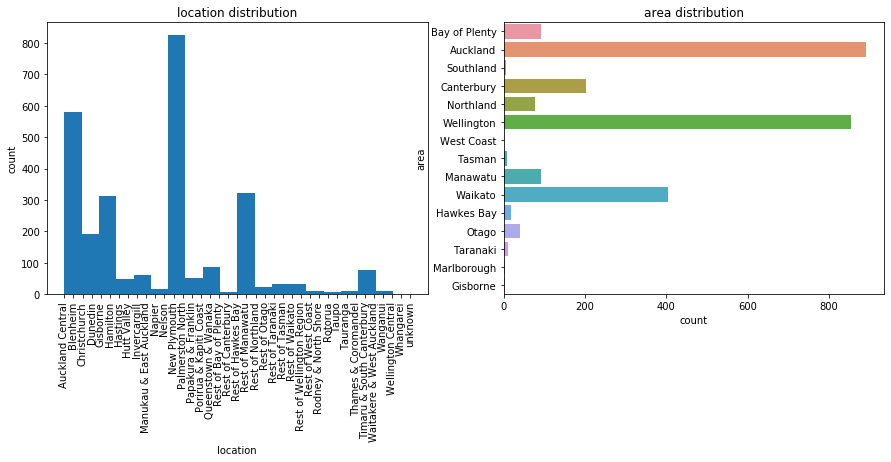

In [404]:
#location distribution
#use matplotlib method 
# nrow = 1 , ncol = 2 

fig,ax  = plt.subplots(1,2,squeeze = False,figsize = (15,5))
ax[0][0].hist(admin_df['location'],bins = 20)
ax[0][0].set_xticklabels(location_count_df['location'],rotation = 90)
ax[0][0].set_ylabel('count')
ax[0][0].set_xlabel('location')
ax[0][0].set_title('location distribution')


#area distrubition
#use seabron method
ax = sns.countplot(y = 'area',data = admin_df, ax = ax[0][1])
ax.set(title = 'area distribution')
plt.show()



# Q: Which post day the difference of low and high salary changes is the largest than others?

## A: From the graph, we can see the difference of the low and high salary changed is the largest is post time 9 days ago.

In [372]:
# change post_time, high_salary, low_salary
admin_df['post_time'] = admin_df['post_time'].astype('str')
admin_df['high_salary'] = admin_df['high_salary'].astype('float32')
admin_df['low_salary'] = admin_df['low_salary'].astype('float32')

[Text(0, 0.5, 'mean of salary'),
 Text(0.5, 0, 'post time'),
 Text(0.5, 1.0, 'salary changes from time to time')]

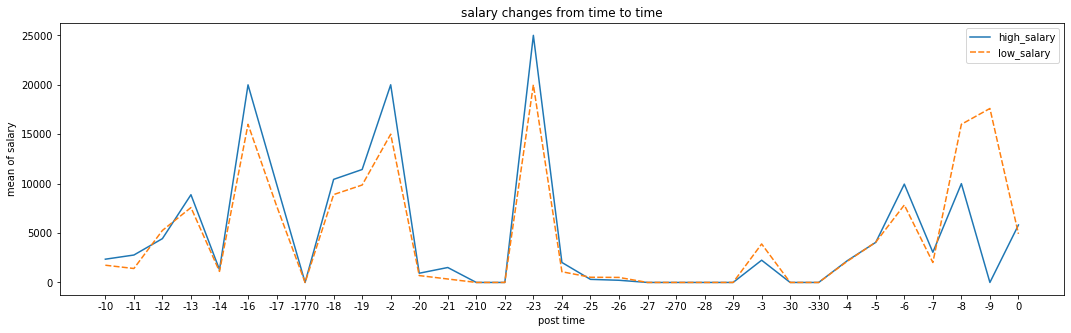

In [373]:
# First, groupby post_time, then calculate mean of high_salary and low_salary's mean.Finally, draw the lineplot.

salary_line = admin_df[['post_time','high_salary','low_salary']].groupby('post_time').mean()
plt.figure(figsize=(18,5))
ax1 = sns.lineplot(data=salary_line)
ax1.set(xlabel = 'post time',ylabel= 'mean of salary',title = 'salary changes from time to time')

# Q: Show the top 5 hottest job.

## A: We can see from the plot, Exective Assistant, Temporary Office Roles, Contracts Administrator, Team Administrator,Temp receptionist are the top 5 hottest job in the difficult location. 

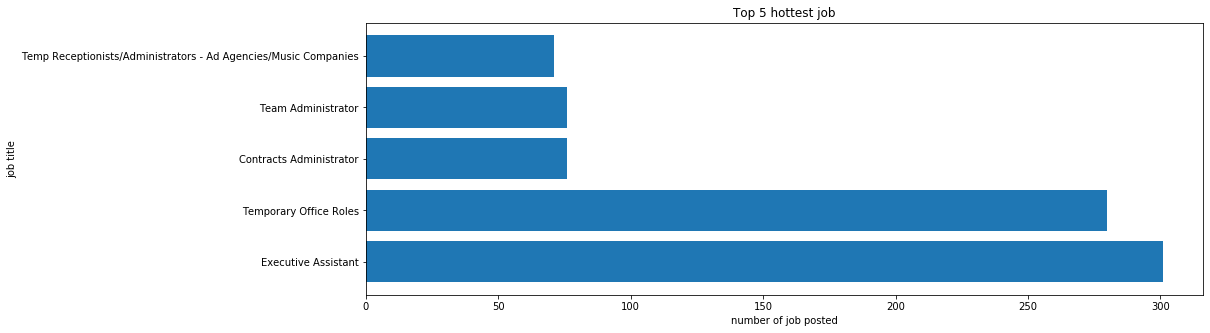

In [391]:
admin_df['count'] = 1
job_title = admin_df[[0,'count']].groupby(admin_df[0],).sum().reset_index()
job_title = job_title.sort_values(by=['count'],ascending=False).head(5)
plt.figure(figsize=(15,5))
plt.barh(job_title[0],job_title['count'])
plt.xlabel('number of job posted')
plt.ylabel('job title')
plt.title('Top 5 hottest job')
plt.show()


# Q: What the most popular classification shares in the market?

## A: Administrative Assistants in the most popular classification shares in the market.

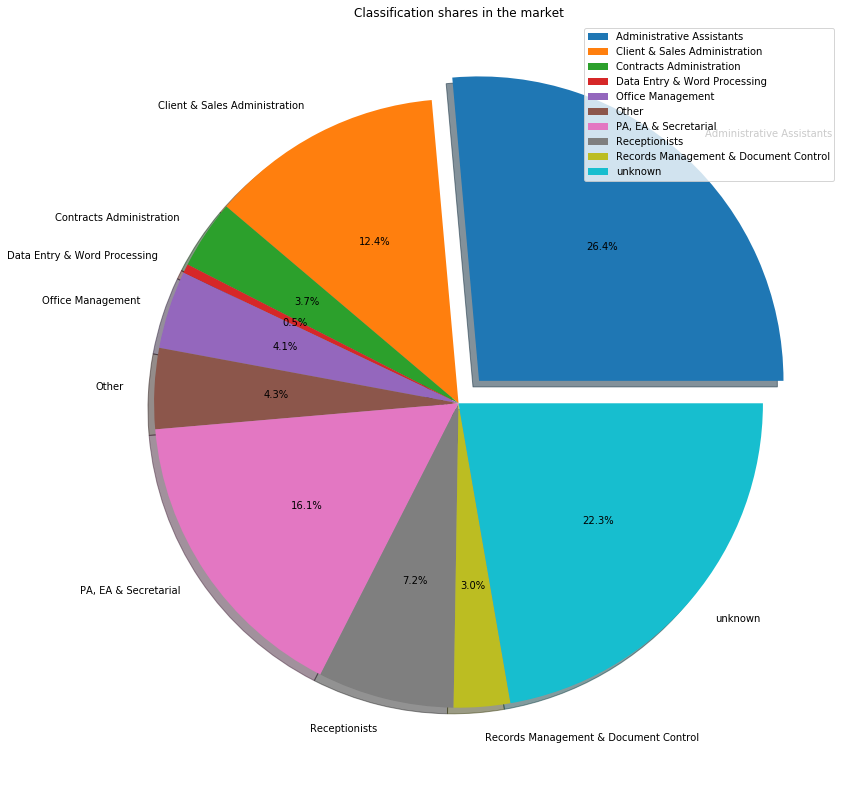

In [454]:
# classification shares in the market.
plt.figure(figsize=(15,14))
admin_df['count1'] = 1

# the data frame named classi_df contain 'classification' and 'count1'
classi_df = admin_df[['count1','classification']].groupby(admin_df['classification']).sum().reset_index()
labels_classi = classi_df['classification']
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)
plt.pie(y, labels = labels_classi, autopct='%1.1f%%',shadow  = True,explode = explode)
plt.title('Classification shares in the market')
plt.legend()
plt.show()